In [1]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization

from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Concatenate, Attention

from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler


2024-02-04 06:37:40.252000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import yfinance as yf

In [3]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [4]:
period = '3000d'


features = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
#features = [ 'Close',]  # Sadece kapanış fiyatını kullanın

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

tickers = ['SOL-USD']




In [5]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)

            veri = veri[features]   
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
            
            
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [6]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [7]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed
SOL-USD verisi csv olarak kaydedildi


In [8]:
scaler  = MinMaxScaler()

#her bir veri çerçevesi için scaled dataset oluştur

if not os.path.exists('datas/scaled_datasets'):
    os.makedirs('datas/scaled_datasets')

scaled_datasets = []

for i in range(len(datasets)):
    scaled_datasets.append(scaler.fit_transform(datasets[i]))
    np.save(f'datas/scaled_datasets/{tickers[i]}.npy', scaled_datasets[i])
    print(f'{tickers[i]} verisi scaled edilerek kaydedildi')
    

SOL-USD verisi scaled edilerek kaydedildi


In [9]:
# her bir veri çerçevesi için veriyi dizilere bölme

seq_length = 60  # Son 60 günü kullanarak
pred_length = 15  # Önümüzdeki 15 günü tahmin etme

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

# her bir veri çerçevesi için veriyi dizilere bölme

if not os.path.exists('datas/sequences'):
    os.makedirs('datas/sequences')

X, y = [], []

for i in range(len(scaled_datasets)):
    X_, y_ = create_sequences(scaled_datasets[i], seq_length, pred_length)
    X.append(X_)
    y.append(y_)
    np.save(f'datas/sequences/X_{tickers[i]}.npy', X_)
    np.save(f'datas/sequences/y_{tickers[i]}.npy', y_)
    print(f'{tickers[i]} verisi dizilere bölünerek kaydedildi')
    


SOL-USD verisi dizilere bölünerek kaydedildi


In [10]:
# her bir veri çerçevesi için veriyi train ve test olarak bölme

X_train, X_test, y_train, y_test = [], [], [], []

for i in range(len(scaled_datasets)):
    X_train_, X_test_, y_train_, y_test_ = X[i][:-pred_length], X[i][-pred_length:], y[i][:-pred_length], y[i][-pred_length:]
    X_train.append(X_train_)
    X_test.append(X_test_)
    y_train.append(y_train_)
    y_test.append(y_test_)
    

In [11]:
# her bir veri çerçevesi için  seq2seq attention modeli oluştur

# Encoder
encoder_inputs = Input(shape=(seq_length, len(features)))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = RepeatVector(pred_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


# Dikkat Mekanizması
attention_layer = Attention(use_scale=True)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])


# TimeDistributed Dense
decoder_dense = TimeDistributed(Dense(len(features)))
decoder_outputs = decoder_dense(decoder_concat_input)

def create_model(encoder_inputs, decoder_outputs):
    model = Model(encoder_inputs, decoder_outputs)
    return model
    


In [12]:
# her bir veri çerçevesi için modeli oluştur ve eğit

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

models = []
batch_size = 64
epochs = 100

for i in range(len(scaled_datasets)):
    # modeli oluştur
    model = create_model(encoder_inputs, decoder_outputs)
    
    # modeli derle
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # modeli listeye ekle
    models.append(model)
    
    # modeli eğit
    models[i].fit(X_train[i], y_train[i], batch_size=batch_size, epochs=epochs, validation_data=(X_test[i], y_test[i]))
    
    # modeli kaydet
    models[i].save(f'datas/models/{tickers[i]}_model.h5')
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')


Epoch 1/100


2024-02-04 06:37:52.623891: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


21/21 [==============================] - 8s 111ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 2/100
 1/21 [>.............................] - ETA: 0s - loss: 0.0050

2024-02-04 06:37:55.371183: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


21/21 [==============================] - 1s 43ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 3/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0034 - val_loss: 0.0061
Epoch 4/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 5/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 7/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 8/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 11/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 12/1

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


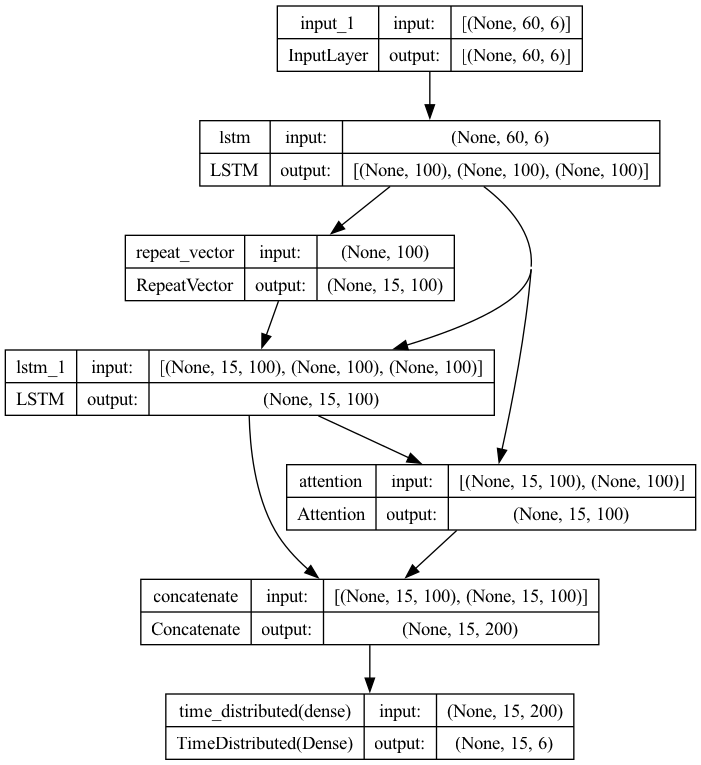

In [13]:
# modelerden bir tanesini png kaydedelim
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='datas/model.png', show_shapes=True, show_layer_names=True , rankdir='TB', expand_nested=True, dpi=96, )

In [14]:
# her bir veri çerçevesi için modeli yükle ve son veri noktasını kullanarak tahmin yap

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
for i in  range(len(models)):
    
    # modeli yükle
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5')
    
    # tahmin yap
    predictions = model.predict(X_test[i])
    
    # tahminleri kaydet
    np.save(f'datas/predictions/{tickers[i]}_predictions.npy', predictions)
    print(f'{tickers[i]} için tahminler kaydedildi')
    

1/1 [==============================] - 1s 1s/step
SOL-USD için tahminler kaydedildi


2024-02-04 06:39:46.025073: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


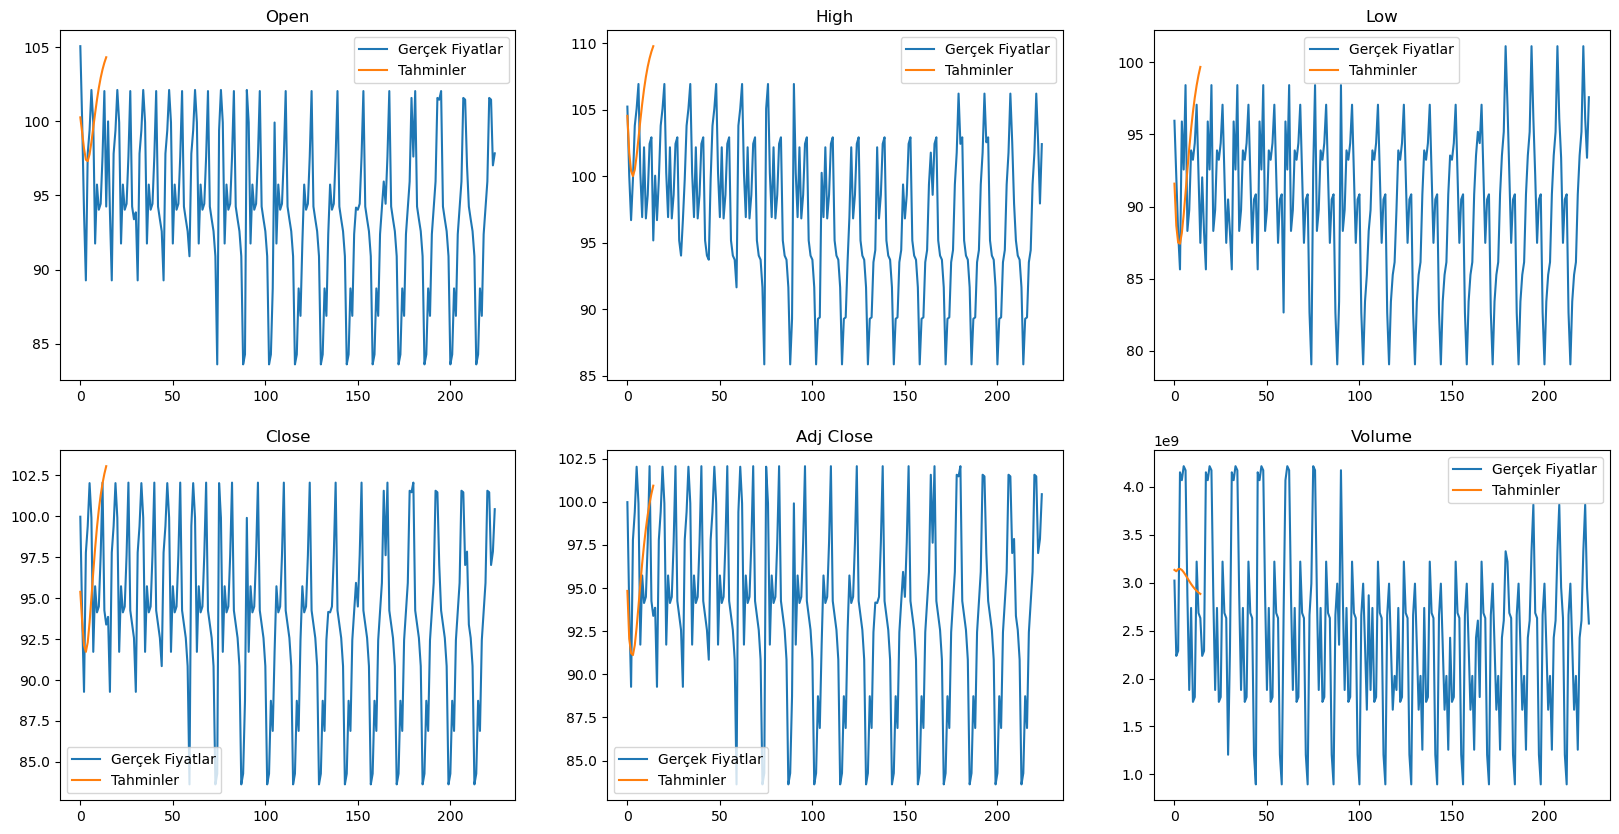

IndexError: list index out of range

In [15]:
# her bir veri çerçevesi için tahminleri gerçek fiyatlarla karşılaştır

for i in range(len(predictions)):
    # gerçek fiyatları al
    gercek_fiyatlar = scaler.inverse_transform(y_test[i].reshape(-1, len(features)))
    
    # tahminleri al
    tahminler = scaler.inverse_transform(predictions[i].reshape(-1, len(features)))
    
    # gerçek fiyatlar ve tahminleri karşılaştır
    plt.figure(figsize=(20, 10))
    for j in range(len(features)):
        plt.subplot(2, 3, j+1)
        plt.plot(gercek_fiyatlar[:, j], label='Gerçek Fiyatlar')
        plt.plot(tahminler[:, j], label='Tahminler')
        plt.title(f'{features[j]}')
        plt.legend()
    plt.show()
    